# MNIST Image Classification

This project is seeking to indetify clusters within the MNIST digit image recognition dataset. This involves analyzing hand written numbers and correctly identifying them. This project also involves comparing the results of different dimensionality reduction techniques and their unique drawbacks or benefits

## Table of Contents
1. PCA Dimensionality Reduction
2. T-SNE Visualization of Clusters
3. K-Means Clustering
4. Hierarchical Clustering

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils import shuffle

In [75]:
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)

#mnist = fetch_openml('mnist_784', version=1, return_X_y=True)
#X = mnist.data / 255.0
#y = mnist.target



In [76]:
print(X.shape)
#so there are 100 features for each observation

(70000, 784)


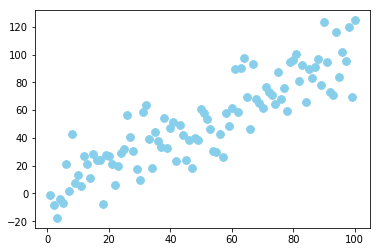

In [77]:
#I just want to look at an initial plot to better understand the data
df= pd.DataFrame({'X': range(1,101), 
                  'y': np.random.randn(100)*15+range(1,101)})
plt.scatter(df['X'], df['y'], c='skyblue', s=60)

## PCA Dimensionality Reduction

Let's first pick the number of componenets that we will use. We can do this by graphing it almost as a cost function with the number of components on the x axis and the fraction of the variance being explained on the y-axis. This is a very rough way of doing it but we can look on this graph to see where the marginal benefit of an additional component begins to taper off or decrease. If we had a specific target explained variance we could find the number of components to explain that target variance. I will be doing the first method though for ease.

Use PCA to reduce the dimensionality







In [78]:
X.shape


(70000, 784)

In [79]:
y.shape

(70000,)

a. How many components did you use? Why?

I'll show both the elbow method and the % variance method.

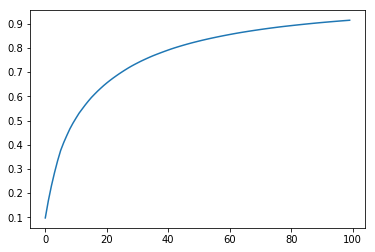

In [80]:
#using the elbow method to find an good amount of components without losing too much variation in my data
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)

Using the elbow method, we can explain around 80% of the data with around 40 components

In [81]:
#Here is the way to select % of variance you want explained and return # of components
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

index_95 = np.argmax(cum_ratio >= 0.80)
print(index_95)

42


This confirmed my elbow method guess. I'm going to go with about 40 components because that will explain almost 80% of the data but significantly reduce the number of features to make my data more manageable. After 40 components the returns to extra complexity in our model (extra components) are decreasing to where PCA starts to lose some of its value in reducing complexity if more than 40 components are used. 


In [82]:
#doing the PCA reduction
pca = PCA(n_components=40)
pca_result = pca.fit_transform(X)
#Lets include a function to see if this worked
print(pca_result.shape)

(70000, 40)


b) Plot the first two components. Do you notice any trends? What is this plot showing us?
Okay great so that worked! Let's look at the first two projectionsb. 

Text(0.5, 1.0, 'First 2 Principle Components')

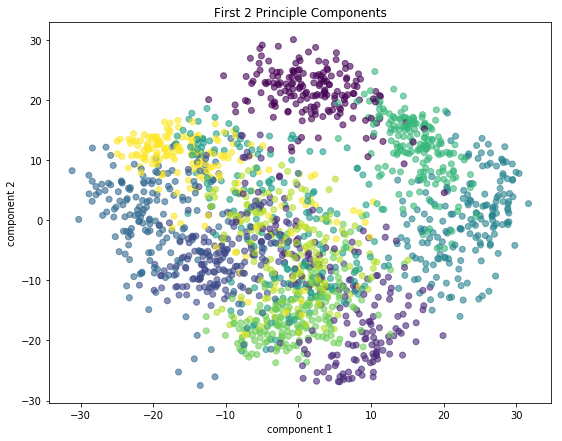

In [108]:
#visualize
#I'm just going to read the data in again in integer form so it doesn't mess up the rest of my code
mnist = datasets.load_digits()
y_RGBA = mnist.target
x_RGBA = mnist.data

pca = PCA(n_components = 2)
data_pca = pca.fit_transform(x_RGBA)

f, ax = plt.subplots(figsize = (9,7))
plt.scatter(data_pca[:, 0], data_pca[:, 1],
            c=y_RGBA, edgecolor='face', alpha=0.6)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('First 2 Principle Components')

This plot is showing us the first two axis that we projected onto which were the axis with the highest variance. We can see this reflected on the graph as Component 1 has greater variation along it than Component 2. Trends we see are that most of the data is on the left of the x-axis, tampering out as we head right. We begin to see some of those clusters but it isn't very clear yet.

c. Why would you use PCA? What is it doing? And what are the drawbacks?
I would use PCA if I have a dataset with a lot of features to get an easier data size that is more manageable and runs faster. This is good for models like a random forest that don't do well with high dimensions. This is balanced with the idea of losing variation in my data as I reduce to fewer features which is a natural drawback to PCA. In addition, it does not visualize well to understand clusters in the data and it is not easily interpretable.  

d. Plot some of the images, then compress them using PCA and plot again. How does it look?

This is a plot of this observation before PCA reduction. It looks like a '3'. Let's run the same observation in our compressed dataset to see how it compares

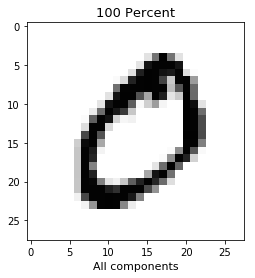

In [52]:
plt.imshow(X[1].reshape((28,28)), cmap='Greys')
plt.xlabel('All components', fontsize=11)
plt.title('100 Percent', fontsize = 13);

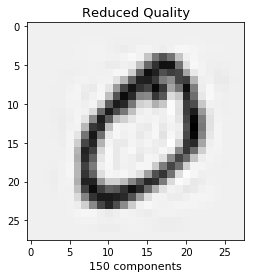

In [53]:
#doing a reduction
pca = PCA(n_components=150)
X_150dim = pca.fit_transform(X)
X_inverse = pca.inverse_transform(X_150dim)
#plotting
plt.imshow(X_inverse[1].reshape((28,28)), cmap='Greys')
plt.xlabel('150 components', fontsize=11)
plt.title('Reduced Quality', fontsize = 13);

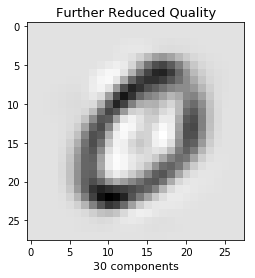

In [54]:
#doing a further reduction
pca = PCA(n_components=30)
X_30dim = pca.fit_transform(X)
#replotting new PCA reduction
X_inverse = pca.inverse_transform(X_30dim)
plt.imshow(X_inverse[1].reshape((28,28)), cmap='Greys')
plt.xlabel('30 components', fontsize=11)
plt.title('Further Reduced Quality', fontsize = 13);

from this we can see that in terms of the example of screen resolution, the amount of pixels to show the picture are decreasing. We are combining features of a data point so that the defining outline is becoming slightly fuzzy but we can still tell it is a 0 with the reduced variation. 

# T-SNE
This model is similar to PCA but is better for visualizing clusters in the data because of how it balances local and global perplexity. 

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 8.660s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 360.293381
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.541252
[t-SNE] KL divergence after 1000 iterations: 1.681569


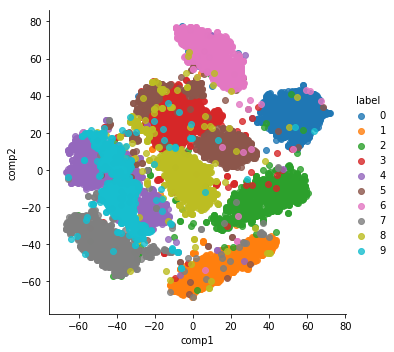

In [57]:
#first reduce dimensionality before feeding to t-sne so we speed up our process since tsne takes a lot longer
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

a. How does this plot differ from your PCA plot?

Instead of just reducing dimensionality, this T-SNE plot is looking to group points into clusters but balancing local and global relationships as it does so which is how we get clustering out of it. Perplexity is what controls the balance between local and global. In TSNE, the clusters are each tighter together and there is more distance between clusters globally. In this plot we this happening versus PCA. There are more defined clusters now. 



b. How robust is it to changes in perplexity?
c. How robust is it to different learning rate and number of iterations?

Lets create for loops to see how the graph changes with changes to perplexity, learning rate, and n_iter

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.038s...
[t-SNE] Computed neighbors for 10000 samples in 15.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 178.773654
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.486534
[t-SNE] KL divergence after 500 iterations: 2.670021
[t-SNE] Computing 151 ne

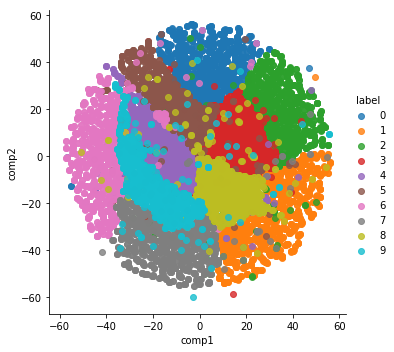

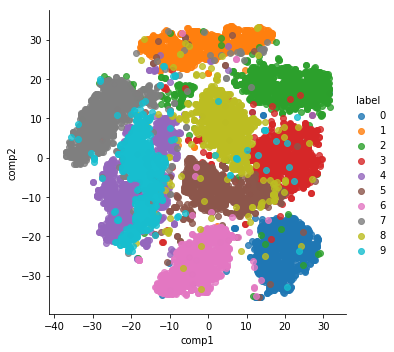

In [109]:
#let's analyze how perplexity changes first
for i in [2, 50]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=500, learning_rate=200)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

From the results it shows that as the perplexity increases, the focus becomes more global because the points in each cluster are becoming closer together and clusters are spreading out from the ball shape. In addition, each cluster is overlapping less so 2 is not a very good perplexity. Research shows between 5 and 50 is usually good

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 8.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 360.293381
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.873337
[t-SNE] KL divergence after 500 iterations: 3.627806
[t-SNE] Computing 151 n

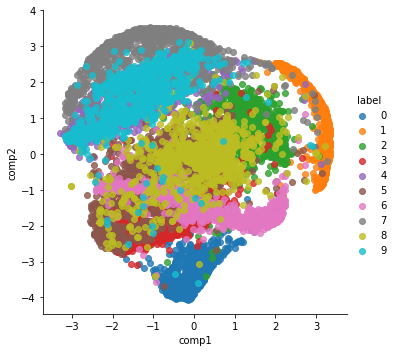

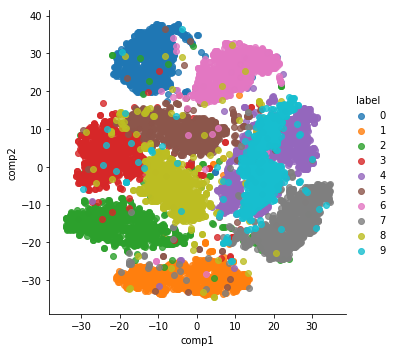

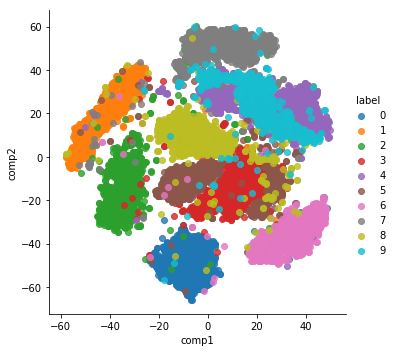

In [58]:
#let's do learning rate next
for i in [2, 200, 2000]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500, learning_rate=i)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 7.473s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 360.293381
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.498871
[t-SNE] KL divergence after 251 iterations: 17976931348623157081452742373170

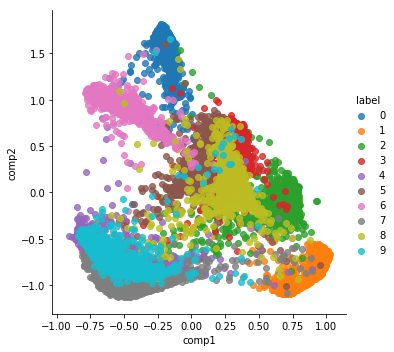

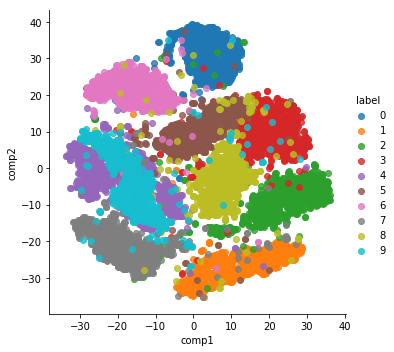

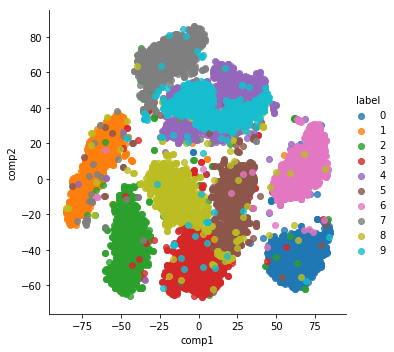

In [59]:
#and lastly lets look at number of iterations
for i in [250, 500, 1500]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=i, learning_rate=200)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)

The learning rate can help avoid getting stuck in a local minimum for the cost function. It appears that learning rate does have quite a significant effect on the grouping. A low learning rate leads to almost a ball and then as it increases the groups seem to separate out a little more to be more defined. the model seems to be a bit more robust at or over a rate of 200 with some groups staying relatively similar with further increases. 

Interactions is how many times the model runs through in optimizing the results. 250 is lowest number of iterations possible. As the number of iterations increased, it appears that each cluster become more defined as with each additional iteration the clusters were optimized that much more. This is also manifested by the clusters spreading out more as points become more closely "entrenched" in their clusters. It seems that as the number of iterations increases past 500 it starts to become a little more robust with some groups staying pretty similar at 500 and above. 

Overall, within a certain threshold for learning rate and the number of iterations things seem fairly robust.

# K-Means Clustering
This model is grouping the data into a set of K-mean clusters that minimizes variation within the clusters by randomly assigning points to a cluster, calculating the centroid, and then reassigning to the closest cluster repeated until no change happens.

Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

-Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

-Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

a. How did you choose k?

K is a hyper parameter that needs to be chosen. Sometimes if it is not intuitive then you can perform the elbow method that uses how tight knit a cluster is to evaluate if it is a good sample. Since we are looking for numbers 0-9 we know that we will need 10 clusters so we can just choose a K of 10. Below is an example however of the elbow method graph

d. Did you scale your data?

I know the data is already kind of scaled in that every feature is on a similar scale. If I were to rescale it, that would distort the distances between points. I did try scaling it too and running it but preferred the unscaled model

In [61]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

b. How did you evaluate your clustering?

I evaluated my clusters using a Silhouette Score which is a measure of how tightly knit our clusters are using the defined metric. This essentially is a measure of the density of each cluster.

In [62]:
#re-scaled model
kmeans = KMeans(n_clusters=10, n_init=50)
kmeans.fit(X_scaled)
labels_train = kmeans.labels_
silhouette_score(X_scaled, labels_train, metric='euclidean')

0.008082196606475175

In [110]:
#unscaled model
kmeans = KMeans(n_clusters=10, n_init=50)
kmeans.fit(X)
labels_train = kmeans.labels_
silhouette_score(X, labels_train, metric='euclidean')

0.05869158808377628

e. How robust is your clustering?

It is pretty robust, each sample (train and test) stayed pretty constant as I ran the model 3 times. I can do this to test robustness because with each time the model runs, it initially randonly assigns datapoints to a cluster. If it keeps converging to the same results, we know our results are robust. 

c. Visualize your clusters using t-sne

Let's do some visualization! We just need to use our K-Means labels instead of tsne labels


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.465s...
[t-SNE] Computed neighbors for 10000 samples in 102.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 424.832375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.714569
[t-SNE] KL divergence after 500 iterations: 2.428853


Text(0.5, 1.0, 'K-Means Clustering')

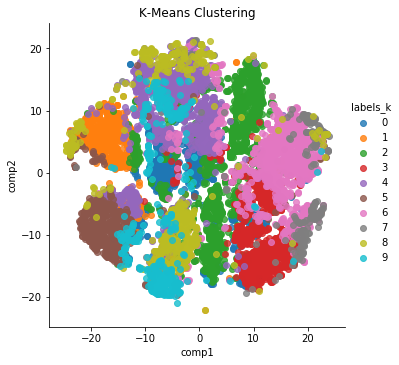

In [64]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500, learning_rate=50)
tsne_results = tsne.fit_transform(X[rows[:n_select],:])

df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['labels_k'] = labels_train[rows[:n_select]]

sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='labels_k', fit_reg=False)
plt.title('K-Means Clustering')

# Hierarchical Clustering
In this model everything starts out as its own cluster. As we go along, similar clusters are grouped together so the earlier clusters group together, the more similar they were. From there we can just pick the relative height that we think is reasonable to have similar clusters all grouped together and draw a horizontal line. The number of vertical lines it crosses are the number of clusters you have. 

In [66]:
#take a sample to make it run faster
X_sub = shuffle(X) [0:300]

a. Plot your dendrogram

For this one, we will use complete as the linkage method which is defined as: Complete - Use the maximum distance between points in clusters

I will be using my X_sub dataset defined in the previous section

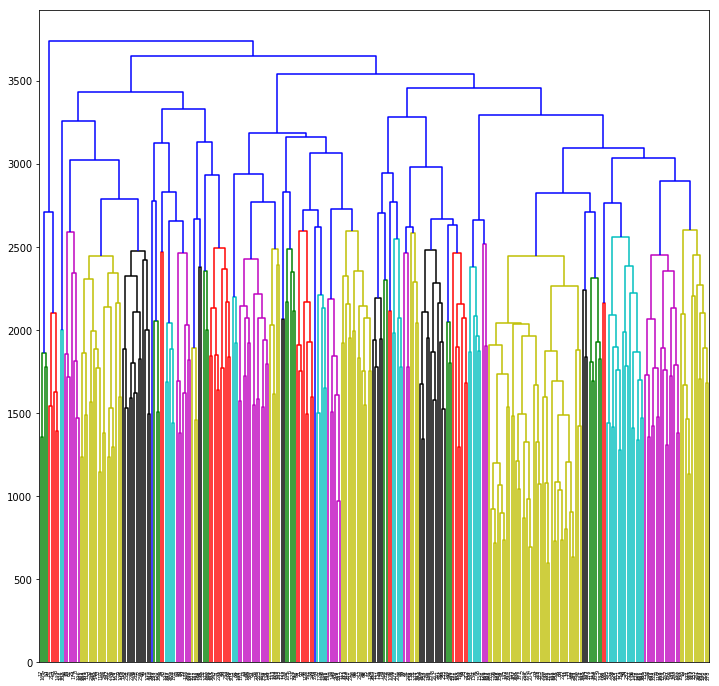

In [67]:
Z = linkage(X_sub, 'complete')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

I will use two different other linkage methods too:

Ward - Merge the two clusters which minimize the total within-cluster variance after merging

Average - Use the average distance between points in clusters

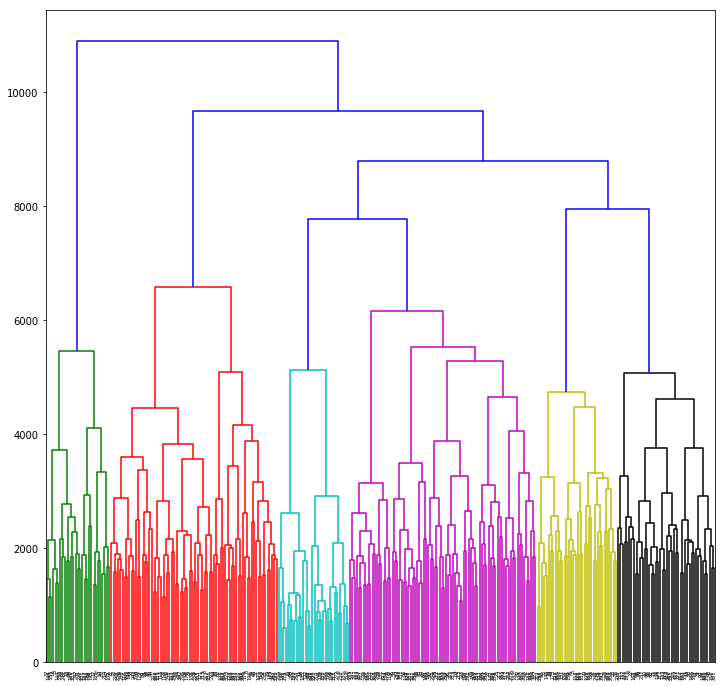

In [68]:
Z = linkage(X_sub, 'ward')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

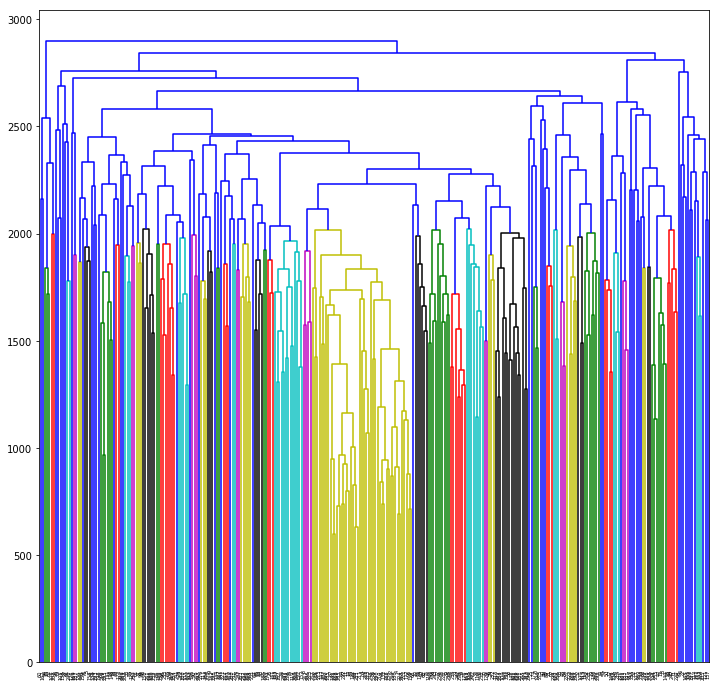

In [69]:
Z = linkage(X_sub, 'average')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

b. How many clusters seem reasonable based off your graph?

Around 10-15 clusters actually seems pretty reasonable based off these graphs. They all seem to link up to this point between 3000-4000 with two of them being around the 3000 range. 

c. How does your dendrogram change with different linkage methods?

It appears that changing the linkages changed how soon different clusters joined with ward seeming to take longer than the others to merge clusters based on the scale of the y-axis. This makes sense because ward is very focused on within cluster variation. Overall though I would say the results visually, in terms of the number of clusters they each recommend, are relatively similar. 